In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve,auc

## 1.1 Dataset size vs. model performance

In [2]:
mth_rolling_features = pd.read_excel('mth_rolling_features.xlsx')
mth_day_counts = pd.read_excel('mth_day_counts.xlsx')
days_since_last_txn = pd.read_excel('days_since_last_txn.xlsx')
retail_data_response = pd.read_csv('Retail_Data_Response.csv')

In [3]:
mth_day_counts['customer_id'].fillna(method='ffill',inplace=True)
monthly_features_outputs = mth_rolling_features.merge(mth_day_counts, how='left', left_on=['CLNT_NO','ME_DT'], right_on=['customer_id','ME_DT'])
monthly_features_outputs.drop(columns='customer_id',inplace=True)
monthly_features_outputs = monthly_features_outputs.merge(days_since_last_txn, how='left', on=['CLNT_NO','ME_DT'])
monthly_features_outputs = monthly_features_outputs.merge(retail_data_response, how='left', left_on='CLNT_NO',right_on='customer_id')
monthly_features_outputs.drop(columns='customer_id',inplace=True)
monthly_features_outputs.fillna(0, inplace=True) # fillna with 0

In [4]:
monthly_features_outputs.head()

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,...,txn_cnt_max_12M,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,days_since_last_txn,response
0,CS1112,2011-05-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-10,0.0
1,CS1112,2011-06-30,56,1,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15,0.0
2,CS1112,2011-07-31,0,0,56.0,18.666667,56.0,1.0,0.333333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46,0.0
3,CS1112,2011-08-31,96,1,152.0,50.666667,96.0,2.0,0.666667,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12,0.0
4,CS1112,2011-09-30,0,0,96.0,32.000000,96.0,1.0,0.333333,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42,0.0


### 1.1.1 Split the train/test sets 

In [5]:
train, test = train_test_split(monthly_features_outputs, test_size=0.1, random_state = 1147)

In [6]:
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (291404, 31)
Test shape: (32379, 31)


### 1.1.2 Create loop and test AUC

The optimal model from Assignment 5 is decision tree with max depth of 6. 

In [7]:
# Define inputs X and output y
X_test = test.iloc[:,2:-1]
y_test = test.iloc[:,-1]

In [8]:
# Loop over 1000 samples of 10 times 
N = 1000
auc_train = []
auc_test = []
for i in range(10): 
    train_temp = train.sample(n=N, random_state=i)
    X_train = train_temp.iloc[:,2:-1]
    y_train = train_temp.iloc[:,-1]
    dt = DecisionTreeClassifier(max_depth = 6, random_state=0)
    dt.fit(X_train, y_train)
    # Score train and test set 
    scores_train = dt.predict_proba(X_train)[:,1] 
    scores_test  = dt.predict_proba(X_test)[:,1]
    # ROC Calc Train set 
    fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
    # ROC Calc Test set w
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    # Calculate the AUCs
    auc_train.append(auc(fpr_train, tpr_train))
    auc_test.append(auc(fpr_test, tpr_test))

In [9]:
mean_test_AUC = np.mean(auc_test)
print('Mean of test AUC', np.round(mean_test_AUC,3))

Mean of test AUC 0.553


In [10]:
std_test_AUC = np.std(auc_test)
print('Standard deviation of test AUC', np.round(std_test_AUC,3))

Standard deviation of test AUC 0.025


### 1.1.3 Repeat for different sample size N

The sample size ranges from 100 to 200,000. The step size is large to observe significant change in AUC. Each sample size has been sampled 10 times. And mean and standard deviation of test AUC is analyzed. 

In [11]:
N_size = [100,1000,5000,10000,50000,100000,200000]
auc_train = np.zeros((len(N_size),10))
auc_test = np.zeros((len(N_size),10))
for N in range(len(N_size)): 
    for i in range(10): 
        train_temp = train.sample(n=N_size[N], random_state=i)
        X_train = train_temp.iloc[:,2:-1]
        y_train = train_temp.iloc[:,-1]
        dt = DecisionTreeClassifier(max_depth = 6, random_state=0)
        dt.fit(X_train, y_train)
        # Score train and test set 
        scores_train = dt.predict_proba(X_train)[:,1] 
        scores_test  = dt.predict_proba(X_test)[:,1]
        # ROC Calc Train set 
        fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
        # ROC Calc Test set 
        fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
        # Calculate the AUCs
        auc_train[N][i] = auc(fpr_train, tpr_train)
        auc_test[N][i] = auc(fpr_test, tpr_test)
    print('N: %d, mean test AUC: %.3f, standard deviation AUC: %.3f'%(N_size[N], np.mean(auc_test[N]), np.std(auc_test[N])))

N: 100, mean test AUC: 0.518, standard deviation AUC: 0.017
N: 1000, mean test AUC: 0.553, standard deviation AUC: 0.025
N: 5000, mean test AUC: 0.587, standard deviation AUC: 0.009
N: 10000, mean test AUC: 0.605, standard deviation AUC: 0.006
N: 50000, mean test AUC: 0.628, standard deviation AUC: 0.003
N: 100000, mean test AUC: 0.632, standard deviation AUC: 0.002
N: 200000, mean test AUC: 0.636, standard deviation AUC: 0.001


In [12]:
# Save mean and std 
mean_auc_test = auc_test.mean(axis=1)
std_auc_test = auc_test.std(axis=1)

### 1.1.4 Build tables 

| Sample size | Test AUC mean | Test AUC standard deviation |
| --- | --- | --- |
| 100 | 0.518 | 0.017 |
| 1000 |0.553 | 0.025 |
| 5000 |0.587 | 0.009 |
| 10000 | 0.605 | 0.006 |
| 50000 | 0.628 | 0.003 |
| 100000 | 0.632 | 0.002|
| 200000 | 0.636 | 0.001 |

From the table, with increasing sample size, test AUC mean increases and standard deviation decreases. 

### 1.1.5 Plot errorbar

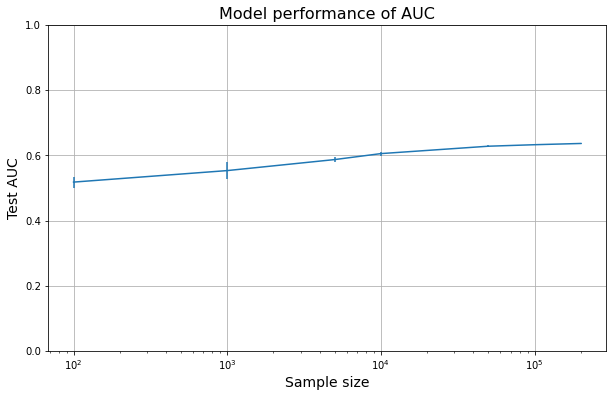

In [13]:
fig = plt.figure(figsize=(10,6))
plt.errorbar(N_size, mean_auc_test, yerr=std_auc_test)
plt.xscale('log')
plt.ylim((0,1))
plt.xlabel('Sample size', fontsize=14)
plt.ylabel('Test AUC', fontsize=14)
plt.title('Model performance of AUC', fontsize=16)
plt.grid()
plt.show()

From the above plot, increasing the number of training samples helps improve model performance, but upon a certain number of samples, the performance reaches a plateau. It is typical for machine learning models that accuracy is limited. It seems 50,000 samples are needed to obtain a good AUC of 0.628. Upon 50,000 samples, increasing number of samples will improve the AUC slightly. Thus, the minimum number of samples needed to model the behaviour adequately is 50,000. The plot also shows increasing the number of training samples will decrease the standard deviation of test AUC, it implies the model performance on test set becomes stable. 